# Setup

In [114]:
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
%matplotlib inline

In [115]:
code_dir=Path.cwd()
project_dir=code_dir.parent
thickness_dir=project_dir/"cat_age_thickness"
input_dir=project_dir/"input"
output_dir=project_dir/"output"
tmp_dir=project_dir/"tmp"

In [116]:
output_dirs = ["gradients", "hub_atrophy", "neighborhood", "spatial_correlations", "structural_connectomes", "functional_connectomes", "thickness_maps", "yeo_networks", "tmp"]

for dir in output_dirs:
    Path(output_dir/dir).mkdir(parents=True, exist_ok=True)

In [117]:
data = pd.read_csv(input_dir/'data_for_subjects_with_resampled_cat_output.csv')
data.shape

(2633, 30)

In [118]:
atlas_resolution=400

In [119]:
thickness_data_array=nib.load(thickness_dir/"RPV.gii").darrays[0]
thickness_pval=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_dir/"RPV.dat", data=None, mmap=False)
thickness_data_array=nib.load(thickness_dir/"beta_0002.gii").darrays[0]
thickness_beta=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_dir/"beta_0002.dat", data=None, mmap=False)

thickness_pval_fdr = np.zeros(thickness_pval.shape[0])
fin_index = np.isfinite(thickness_pval)
thickness_pval_fdr[fin_index] = multipletests(thickness_pval[fin_index], alpha=0.05, method="fdr_bh")[1]
thickness_pval_fdr[~fin_index] = None

thickness_pval_fdr_sig = thickness_pval_fdr.copy()
thickness_beta_fdr_sig = thickness_beta.copy()

thickness_pval_fdr_sig[thickness_pval_fdr >= 0.05] = None
thickness_beta_fdr_sig[thickness_pval_fdr >= 0.05] = None

## Effects: surface to parcel

In [120]:
from enigmatoolbox.utils.parcellation import surface_to_parcel, parcel_to_surface
from statsmodels.stats.multitest import multipletests

# Parcellate vertexwise data

thickness_beta_schaefer = surface_to_parcel(thickness_beta, f'schaefer_{atlas_resolution}_conte69')[1:]
thickness_pval_schaefer = surface_to_parcel(thickness_pval, f'schaefer_{atlas_resolution}_conte69')[1:]
thickness_pval_fdr_schaefer = np.zeros(thickness_pval_schaefer.shape[0])

fin_index = np.isfinite(thickness_pval_schaefer)
thickness_pval_fdr_schaefer[fin_index] = multipletests(thickness_pval_schaefer[fin_index], alpha=0.05, method="fdr_bh")[1]
thickness_pval_fdr_schaefer[~fin_index] = None

In [121]:
thickness_beta_schaefer_df=pd.DataFrame(thickness_beta_schaefer)
#thickness_beta_schaefer_df.fillna(0, inplace=True)

thickness_pval_fdr_schaefer_df=pd.DataFrame(thickness_pval_fdr_schaefer)
thickness_pval_fdr_schaefer_df.fillna(thickness_pval_fdr_schaefer_df.mean(), inplace=True)

# Visualize ThicknessXAge betas

In [122]:
%load_ext autoreload
%autoreload 2
from python_functions.surface_contextualization import plot_surface # https://csi-hamburg.github.io/python_functions

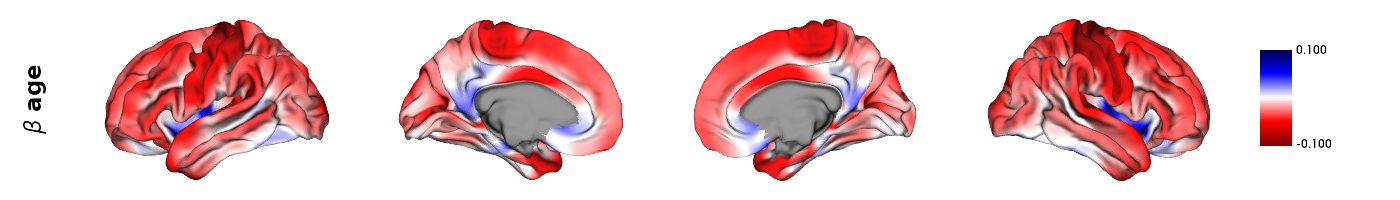

In [124]:
img = plot_surface(
    "fslr32k", 
    thickness_beta, 
    r'$\beta$ age', 
    cmap='seismic_r',
    color_range=(-0.1,0.1)); img

In [125]:
open(output_dir/"thickness_maps/thickness_age_beta.png", "wb").write(img.data)

221389

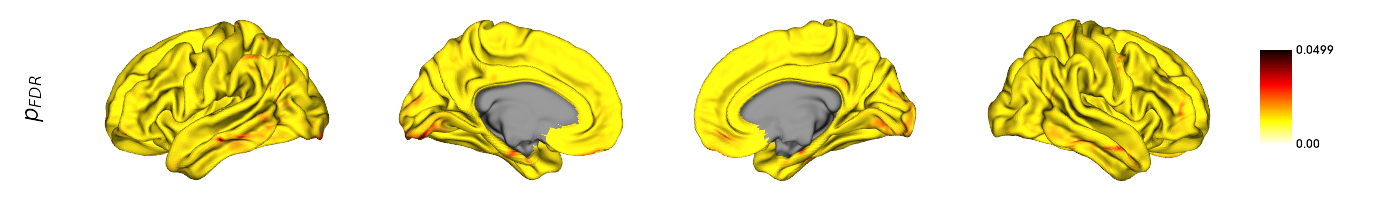

In [126]:
img = plot_surface(
    "fslr32k", 
    thickness_pval_fdr_sig, 
    r'$p_{FDR}$',
    cmap='hot_r'); img

In [127]:
open(output_dir/"thickness_maps/thickness_age_pval.png", "wb").write(img.data)

207869

# Import connectivity data

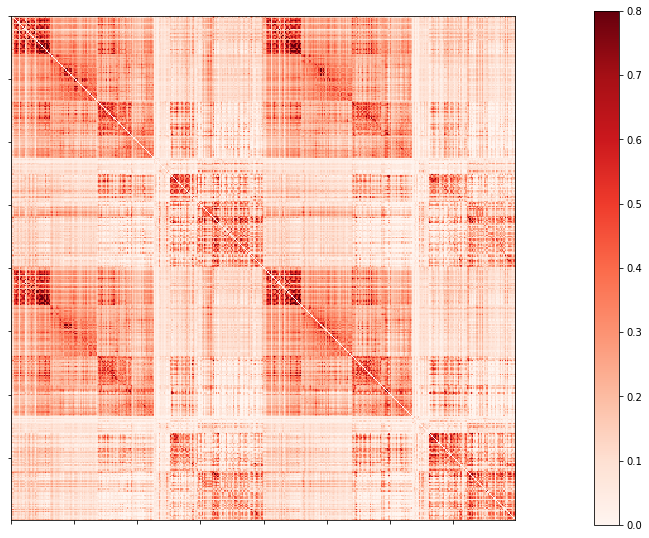

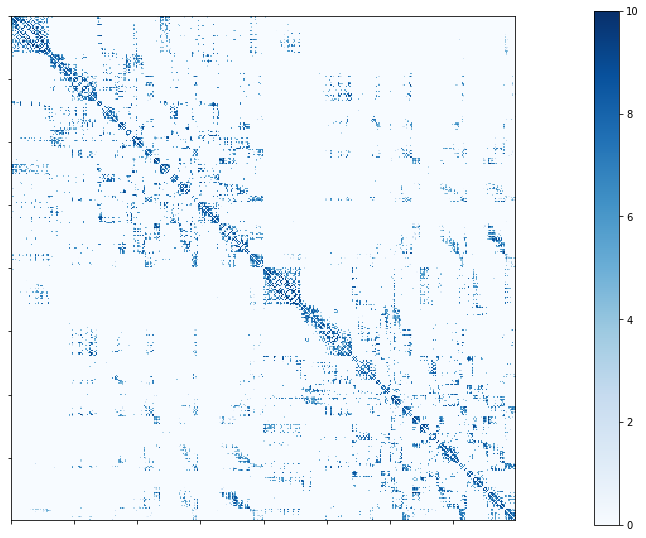

In [129]:
from enigmatoolbox.datasets import load_sc, load_fc

from nilearn import plotting

# Load cortico-cortical functional connectivity data

fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation=f'schaefer_{atlas_resolution}')

# Load cortico-cortical structural connectivity data

sc_ctx, sc_ctx_labels, _, _ = load_sc(parcellation=f'schaefer_{atlas_resolution}')

# Plot cortico-cortical connectivity matrices

fc_plot = plotting.plot_matrix(fc_ctx, figure=(9, 9), vmax=0.8, vmin=0, cmap='Reds')
fc_plot.write_png(output_dir/"functional_connectomes/fc_matrix.png")

sc_plot = plotting.plot_matrix(sc_ctx, figure=(9, 9), vmax=10, vmin=0, cmap='Blues')
sc_plot.write_png(output_dir/"structural_connectomes/sc_matrix.png")

# Hub susceptibility

## Identify cortical hubs

In [132]:
%load_ext autoreload
%autoreload 2
from python_functions.surface_contextualization import weighted_degree_centrality, yeo_participation_coefficient # https://csi-hamburg.github.io/python_functions

import numpy as np

from enigmatoolbox.plotting import plot_cortical

from enigmatoolbox.utils.parcellation import parcel_to_surface

result_dictionary = dict()

In [134]:
# Compute weighted degree centrality measures from the connectivity data
fc_ctx_dc = weighted_degree_centrality(fc_ctx, rank=False)
sc_ctx_dc = weighted_degree_centrality(sc_ctx, rank=False)
fc_ctx_dc_rank = weighted_degree_centrality(fc_ctx, rank=True)
sc_ctx_dc_rank = weighted_degree_centrality(sc_ctx, rank=True)

# Project the results on the surface brain
img = plot_cortical(array_name=parcel_to_surface(fc_ctx_dc + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_degree.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_dc + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_degree.png")

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_dc_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_degree_rank.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_dc_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_degree_rank.png")

In [135]:
fc_ctx_df = pd.DataFrame(fc_ctx, index=fc_ctx_labels, columns=fc_ctx_labels)
sc_ctx_df = pd.DataFrame(sc_ctx, index=sc_ctx_labels, columns=sc_ctx_labels)

fc_ctx_pc = yeo_participation_coefficient(fc_ctx_df, rank=False)
sc_ctx_pc = yeo_participation_coefficient(sc_ctx_df, rank=False)
fc_ctx_pc_rank = np.argsort(np.argsort(fc_ctx_pc * -1))
sc_ctx_pc_rank = np.argsort(np.argsort(sc_ctx_pc * -1))
fc_ctx_inverse_pc_rank = np.argsort(np.argsort(fc_ctx_pc))
sc_ctx_inverse_pc_rank = np.argsort(np.argsort(sc_ctx_pc))


# Project the results on the surface brain

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_pc, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(0.5,fc_ctx_pc.max()), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_pc.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_pc, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(0.5,fc_ctx_pc.max()), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_pc.png")

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_pc_rank, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_pc_rank.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_pc_rank, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_pc_rank.png")

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_inverse_pc_rank, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_pc_inverse_rank.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_inverse_pc_rank, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_pc_inverse_rank.png")

In [139]:
hubness_dictionary = dict()

In [140]:
hubness_dictionary["functional_degree_centrality"] = (np.nan,np.nan,np.nan,fc_ctx_dc)
hubness_dictionary["structural_degree_centrality"] = (np.nan,np.nan,np.nan,sc_ctx_dc)
hubness_dictionary["functional_degree_centrality_rank"] = (np.nan,np.nan,np.nan,fc_ctx_dc_rank)
hubness_dictionary["structural_degree_centrality_rank"] = (np.nan,np.nan,np.nan,sc_ctx_dc_rank)
hubness_dictionary["functional_participation_coefficient"] = (np.nan,np.nan,np.nan,fc_ctx_pc)
hubness_dictionary["structural_participation_coefficient"] = (np.nan,np.nan,np.nan,sc_ctx_pc)
hubness_dictionary["functional_participation_coefficient_rank"] = (np.nan,np.nan,np.nan,fc_ctx_pc_rank)
hubness_dictionary["structural_participation_coefficient_rank"] = (np.nan,np.nan,np.nan,sc_ctx_pc_rank)

In [136]:
fc_ctx_connector_hub_rank = np.argsort(np.argsort(fc_ctx_dc_rank + fc_ctx_pc_rank))
sc_ctx_connector_hub_rank = np.argsort(np.argsort(sc_ctx_dc_rank + sc_ctx_pc_rank))
fc_ctx_provincial_hub_rank = np.argsort(np.argsort(fc_ctx_dc_rank + fc_ctx_inverse_pc_rank))
sc_ctx_provincial_hub_rank = np.argsort(np.argsort(sc_ctx_dc_rank + sc_ctx_inverse_pc_rank))

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_connector_hub_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_connector_hubs.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_connector_hub_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_connector_hubs.png")

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_provincial_hub_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_provincial_hubs.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_provincial_hub_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_provincial_hubs.png")

# Hub atrophy correlations

In [ ]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Functional connector hubness"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    fc_ctx_connector_hub_rank,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,fc_ctx_connector_hub_rank)

In [263]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Functional provincial hubness"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    fc_ctx_provincial_hub_rank,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,fc_ctx_provincial_hub_rank)

In [264]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Structural connector hubness"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    sc_ctx_connector_hub_rank,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,sc_ctx_connector_hub_rank)

In [265]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Structural provincial hubness"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    sc_ctx_provincial_hub_rank,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,sc_ctx_provincial_hub_rank)

# Neighborhood atrophy

In [28]:
from python_functions.surface_contextualization import neighborhood_abnormality # https://csi-hamburg.github.io/python_functions

In [29]:
from enigmatoolbox.plotting import plot_cortical

nghbr_fc_schaefer = neighborhood_abnormality(fc_ctx, thickness_beta_schaefer, fc_ctx_labels)
nghbr_sc_schaefer = neighborhood_abnormality(sc_ctx, thickness_beta_schaefer, sc_ctx_labels)

plot_cortical(array_name=parcel_to_surface(nghbr_fc_schaefer, f'schaefer_{atlas_resolution}_conte69'), 
                surface_name="conte69", size=(800, 200),
                cmap='Reds_r', color_bar=True, embed_nb=True, 
                interactive=True, transparent_bg=False, nan_color=(211,211,211,1), screenshot=True,
                filename=f"{output_dir}/neighborhood/fc_neighborhood.png")

plot_cortical(array_name=parcel_to_surface(nghbr_sc_schaefer, f'schaefer_{atlas_resolution}_conte69'), 
                surface_name="conte69", size=(800, 200),
                cmap='Blues_r', color_bar=True, embed_nb=True, 
                interactive=True, transparent_bg=False, nan_color=(211,211,211,1), screenshot=True,
                filename=f"{output_dir}/neighborhood/sc_neighborhood.png")

'/home/marvin/mount/hdd8tb/CSI_HCHS/2021_petersen_ageing_atrophy_connectomics/output/neighborhood/sc_neighborhood.png'

In [289]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Functional neighborhood abnormality"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    nghbr_fc_schaefer,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,nghbr_fc_schaefer)

In [290]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Structural neighborhood abnormality"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    nghbr_sc_schaefer,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,nghbr_sc_schaefer)

# Gradient analysis

In [30]:
from python_functions.surface_contextualization import connectivity_gradients # https://csi-hamburg.github.io/python_functions


In [31]:
fc_grad1_schaefer, gm = connectivity_gradients(fc_ctx, 0, atlas_resolution=400)
fc_grad1_schaefer = fc_grad1_schaefer * -1 
fc_grad2_schaefer, _ = connectivity_gradients(fc_ctx, 1, atlas_resolution=400)

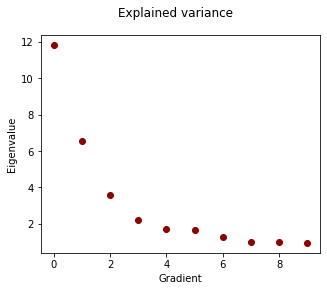

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_, color="darkred")
ax.set_xlabel('Gradient')
ax.set_ylabel('Eigenvalue')

fig.suptitle("Explained variance")

plt.savefig(output_dir/"gradients/eigenvalues_funcgrad.png")
plt.show()

## Functional gradient atrophy correlations

In [33]:
img = plot_cortical(array_name=parcel_to_surface(fc_grad1_schaefer, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/gradients/functional_gradient1.png")
img = plot_cortical(array_name=parcel_to_surface(fc_grad2_schaefer, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/gradients/functional_gradient2.png")

In [295]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Functional connectivity gradient 1"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    fc_grad1_schaefer,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,fc_grad1_schaefer)

In [296]:
from python_functions.surface_contextualization import perform_spins # https://csi-hamburg.github.io/python_functions

analysis = "Functional connectivity gradient 2"
analysis_lower=analysis.replace(" ","_").lower()

r, p, d = perform_spins(
    fc_grad2_schaefer,
    thickness_beta_schaefer,
    atlas_resolution="400")

result_dictionary[analysis_lower] = (r,p,d,fc_grad2_schaefer)

In [297]:
result_dictionary.keys()

dict_keys(['functional_connector_hubness', 'functional_provincial_hubness', 'structural_connector_hubness', 'structural_provincial_hubness', 'functional_neighborhood_abnormality', 'structural_neighborhood_abnormality', 'functional_connectivity_gradient_1', 'functional_connectivity_gradient_2'])

In [298]:
import pickle
with open(tmp_dir/"result_dict.pickle", "wb") as pickle_file:
    pickle.dump(result_dictionary, pickle_file)

In [34]:
import pickle
with open(tmp_dir/"result_dict.pickle", "rb") as pickle_file:
    result_dictionary = pickle.load(pickle_file)

# Compute network null models

In [53]:
from scipy.io import loadmat

fc_rewired_nulls = loadmat(code_dir/f"rewiring_null/fc_rewired_nulls_schaefer{atlas_resolution}.mat")[f'fc_result_mat_{atlas_resolution}']
sc_rewired_nulls = loadmat(code_dir/f"rewiring_null/sc_rewired_nulls_schaefer{atlas_resolution}.mat")[f'sc_result_mat_{atlas_resolution}']

In [54]:
from python_functions.surface_contextualization import *

In [55]:
def get_connector_hub_rank(mat, labels = fc_ctx_labels):
    if type(mat) != pd.core.frame.DataFrame:
            mat = pd.DataFrame(mat, columns=fc_ctx_labels, index=fc_ctx_labels)
    dc_rank = weighted_degree_centrality(mat, rank=True)
    pc_rank = np.argsort(np.argsort(yeo_participation_coefficient(mat, rank=False) * -1))
    hub_rank = np.argsort(np.argsort(dc_rank + pc_rank))
    print(dc_rank)

    return hub_rank.values

In [56]:
def get_provincial_hub_rank(mat, labels = fc_ctx_labels):
    if type(mat) != pd.core.frame.DataFrame:
            mat = pd.DataFrame(mat, columns=fc_ctx_labels, index=fc_ctx_labels)
    dc_rank = weighted_degree_centrality(mat, rank=True)
    pc_rank = np.argsort(np.argsort(yeo_participation_coefficient(mat, rank=False)))
    hub_rank = np.argsort(np.argsort(dc_rank + pc_rank))
    print(dc_rank)

    return hub_rank.values

In [57]:
def get_functional_gradient_1(mat): 

    return connectivity_gradients(mat, 0, atlas_resolution=atlas_resolution)[0] * -1

def get_functional_gradient_2(mat): 

    return connectivity_gradients(mat, 1, atlas_resolution=atlas_resolution)[0]

In [58]:
def get_neighborhood_abnormality(mat): 
    # if type(mat) == pd.core.frame.DataFrame:
    #     mat = mat.values
    return neighborhood_abnormality(mat, thickness_beta_schaefer, fc_ctx_labels)

In [59]:
def get_betzel_permuted_scores(i, null_model_array, reference_score, functions):

    null = null_model_array[:,:,i] + null_model_array[:,:,i].T

    import pingouin as pg
    import pandas as pd 

    
    iter_r_dict = dict()
    iter_score_dict = dict()

    for f in functions:
    
        score = f(null)
        iter_score_dict[f.__name__] = score

        print(score.squeeze().shape)
        print(thickness_beta_schaefer.squeeze().shape)

        iter_r_dict[f.__name__] = pg.corr(score.squeeze(), thickness_beta_schaefer.squeeze(), method='spearman')["r"][0]

    if i % 50 == 0:
        print(i)

    return iter_r_dict, iter_score_dict

In [ ]:
from joblib import Parallel, delayed
parallel_output_func = Parallel(n_jobs=16)(delayed(get_betzel_permuted_scores)(idx, fc_rewired_nulls, thickness_beta_schaefer, [get_connector_hub_rank, get_provincial_hub_rank, get_neighborhood_abnormality, get_functional_gradient_1, get_functional_gradient_2]) for idx in range(1000))

In [ ]:
parallel_output_struc = Parallel(n_jobs=16)(delayed(get_betzel_permuted_scores)(idx, sc_rewired_nulls, thickness_beta_schaefer, [get_connector_hub_rank, get_provincial_hub_rank, get_neighborhood_abnormality]) for idx in range(1000))

In [62]:
import pickle
with open(tmp_dir/"result_dict_betzel_func.pickle", "wb") as pickle_file:
    pickle.dump(parallel_output_func, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

import pickle
with open(tmp_dir/"result_dict_struc.pickle", "wb") as pickle_file:
    pickle.dump(parallel_output_struc, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

# with open(tmp_dir/"result_dict_betzel_func.pickle", "rb") as pickle_file:
#     parallel_output_func = pickle.load(pickle_file)

# with open(tmp_dir/"result_dict_betzel_struc.pickle", "rb") as pickle_file:
#     parallel_output_struc = pickle.load(pickle_file)

In [63]:
r_dicts_func = [parallel_output_func[idx][0] for idx in range(len(parallel_output_func))]
r_dicts_struc = [parallel_output_struc[idx][0] for idx in range(len(parallel_output_struc))]
r_df = pd.DataFrame(r_dicts_func).join(pd.DataFrame(r_dicts_struc), lsuffix="_func", rsuffix="_struc")

In [64]:
r_df

,get_connector_hub_rank_func,get_provincial_hub_rank_func,get_neighborhood_abnormality_func,get_functional_gradient_1,get_functional_gradient_2,get_connector_hub_rank_struc,get_provincial_hub_rank_struc,get_neighborhood_abnormality_struc
0,-0.085436,0.268182,0.308098,-0.125314,-0.330731,0.002019,0.229287,0.594611
1,-0.094311,0.247801,0.261976,0.004820,-0.375861,0.010222,0.235905,0.585531
2,-0.131314,0.251564,0.268975,-0.179853,-0.325360,0.002270,0.216358,0.586719
3,-0.150735,0.240829,0.267400,-0.162414,-0.304795,0.019675,0.246546,0.580980
4,-0.191115,0.272959,0.219546,-0.104534,-0.326851,0.011696,0.230578,0.605534
...,...,...,...,...,...,...,...,...
995,-0.088562,0.250447,0.262253,0.018727,-0.334472,-0.003343,0.215904,0.603420
996,-0.130708,0.234316,0.273157,-0.172062,-0.341050,0.007518,0.242013,0.593077
997,-0.127758,0.270130,0.276955,-0.083945,0.295042,-0.004375,0.216726,0.573663
998,-0.140429,0.271274,0.256820,-0.087694,0.282867,-0.007336,0.215582,0.586129


In [65]:
functional_analyses=["Functional connector hubness", "Functional provincial hubness",
     "Functional neighborhood abnormality",
    "Functional connectivity gradient 1", "Functional connectivity gradient 2"]
functional_analyses_lower = [analysis.replace(" ","_").lower() for analysis in functional_analyses]

In [66]:
structural_analyses=["Structural connector hubness", "Structural provincial hubness", "Structural neighborhood abnormality"]
structural_analyses_lower = [analysis.replace(" ","_").lower() for analysis in structural_analyses]

In [67]:
result_dictionary.keys()

dict_keys(['functional_connector_hubness', 'functional_provincial_hubness', 'structural_connector_hubness', 'structural_provincial_hubness', 'functional_neighborhood_abnormality', 'structural_neighborhood_abnormality', 'functional_connectivity_gradient_1', 'functional_connectivity_gradient_2'])

In [68]:

r_functional_analyses = [result_dictionary[analysis][0] for analysis in functional_analyses_lower]
r_functional_analyses_dict = dict(zip(functional_analyses_lower, r_functional_analyses))

In [69]:

r_structural_analyses = [result_dictionary[analysis][0] for analysis in structural_analyses_lower]
r_structural_analyses_dict = dict(zip(structural_analyses_lower, r_structural_analyses))

In [70]:
r_combined = r_functional_analyses + r_structural_analyses
analyses_lower = functional_analyses_lower + structural_analyses_lower

In [73]:
p_value_dict_betzel = dict()
for idx,col in enumerate(r_df.columns):
    p_value_right_tailed = np.mean(r_combined[idx] > r_df[col])
    p_value_left_tailed = np.mean(r_combined[idx] < r_df[col])
    p_value_two_tailed = np.minimum(p_value_right_tailed, p_value_left_tailed) * 2
    p_value_dict_betzel[analyses_lower[idx]] = p_value_two_tailed
    if col == "structural_provincial_hubness": break

In [76]:
p_value_dict_betzel

{'functional_connector_hubness': 0.646,
 'functional_provincial_hubness': 0.834,
 'functional_neighborhood_abnormality': 0.026,
 'functional_connectivity_gradient_1': 0.0,
 'functional_connectivity_gradient_2': 0.002,
 'structural_connector_hubness': 0.0,
 'structural_provincial_hubness': 0.536,
 'structural_neighborhood_abnormality': 0.002}

# Node metrics to csv

In [101]:
result_dictionary.keys()

dict_keys(['functional_connector_hubness', 'functional_provincial_hubness', 'structural_connector_hubness', 'structural_provincial_hubness', 'functional_neighborhood_abnormality', 'structural_neighborhood_abnormality', 'functional_connectivity_gradient_1', 'functional_connectivity_gradient_2'])

In [145]:
key = "functional_connector_hubness"
schaefer400_metric_dict = dict()
for key in result_dictionary.keys():
    schaefer400_metric_dict[key] = result_dictionary[key][3]
for key in hubness_dictionary.keys():
    schaefer400_metric_dict[key] = hubness_dictionary[key][3]

In [148]:
schaefer400_metric_df = pd.DataFrame(schaefer400_metric_dict, index=fc_ctx_labels)
schaefer400_metric_df.to_csv(output_dir/"spatial_correlations/schaefer400_metrics.csv")

# BrainSMASH permutations

In [77]:
pd.DataFrame(thickness_beta_schaefer).loc[:(thickness_beta_schaefer.shape[0]/2 - 1)].to_csv(input_dir/f"brainsmash/thickness_beta_schaefer{atlas_resolution}_left.txt", index=False, header=False, na_rep=np.nan)
pd.DataFrame(thickness_beta_schaefer).loc[(thickness_beta_schaefer.shape[0]/2):].to_csv(input_dir/f"brainsmash/thickness_beta_schaefer{atlas_resolution}_right.txt", index=False, header=False, na_rep=np.nan)

In [79]:
from brainsmash.mapgen.base import Base
resolution=400
brain_map_file_left = str(input_dir/f"brainsmash/thickness_beta_schaefer{resolution}_left.txt")  # use absolute paths if necessary!
brain_map_file_right = str(input_dir/f"brainsmash/thickness_beta_schaefer{resolution}_right.txt")  # use absolute paths if necessary!
dist_mat_file_left = str(input_dir/f"brainsmash/Left{resolution}SchaeferGeodesicDistmat.txt")
dist_mat_file_right = str(input_dir/f"brainsmash/Right{resolution}SchaeferGeodesicDistmat.txt")

base_left = Base(x=brain_map_file_left, D=dist_mat_file_left)
base_right = Base(x=brain_map_file_right, D=dist_mat_file_right)

surrogates_left = base_left(n=1000)
surrogates_right = base_right(n=1000)

surrogates = np.hstack([surrogates_left, surrogates_right])

np.save(str(input_dir/f"brainsmash/thickness_beta_schaefer{resolution}_surrogates.npy"),surrogates)

surrogates = np.load(str(input_dir/f"brainsmash/thickness_beta_schaefer{resolution}_surrogates.npy"))

brainsmash_surrogates = pd.DataFrame(surrogates)

import pingouin as pg
map_list = [fc_ctx_connector_hub_rank, fc_ctx_provincial_hub_rank, sc_ctx_connector_hub_rank, sc_ctx_provincial_hub_rank, nghbr_fc_schaefer, nghbr_sc_schaefer, fc_grad1_schaefer, fc_grad2_schaefer]
r_dict_brainsmash = dict()
for idx,map in enumerate(map_list):
    r_dict_brainsmash[list(result_dictionary.keys())[idx]] = list(brainsmash_surrogates.apply(lambda x: pg.corr(x,map, method="spearman")["r"][0], axis=1))

brainsmash_surrogates = pd.DataFrame(brainsmash_surrogates)

r_df_brainsmash = pd.DataFrame(r_dict_brainsmash)

p_value_dict_brainsmash = dict()
for idx,key in enumerate(r_dict_brainsmash.keys()):
    p_value_right_tailed = np.mean(result_dictionary[key][0] > r_dict_brainsmash[key])
    p_value_left_tailed = np.mean(result_dictionary[key][0] < r_dict_brainsmash[key])
    p_value_two_tailed = np.minimum(p_value_right_tailed, p_value_left_tailed) * 2
    p_value_dict_brainsmash[key] = p_value_two_tailed

In [82]:
p_value_dict_brainsmash

{'functional_connector_hubness': 0.32,
 'functional_provincial_hubness': 0.046,
 'structural_connector_hubness': 0.838,
 'structural_provincial_hubness': 0.044,
 'functional_neighborhood_abnormality': 0.142,
 'structural_neighborhood_abnormality': 0.0,
 'functional_connectivity_gradient_1': 0.006,
 'functional_connectivity_gradient_2': 0.0}

# Plot scatterplots

In [99]:
def plot_spatial_correlation(analysis, p_rewired, p_brainsmash):
    from python_functions.surface_contextualization import plot_null_distributions # https://csi-hamburg.github.io/python_functions

    analysis_lower=analysis.replace(" ","_").lower()
    (r,p,d,_) = result_dictionary[analysis_lower]

    from python_functions.plotting import plot_scatter # https://csi-hamburg.github.io/python_functions
    for pval in [p, p_rewired, p_brainsmash]:
        if type(pval) != str: 
            if pval < 0.001 : pval = "<0.001"
        else:
            if float(pval) <0.001: pval = "<0.001"

    map_schaefer = result_dictionary[analysis_lower][3]
    beta_schaefer = thickness_beta_schaefer

    cmap = "Reds"
    p_sensitivity = p_brainsmash
    sensitivity_type = r"$p_{smash}$"

    if "neighborhood" in analysis_lower:
        analysis = analysis.replace("abnormality","alteration")
        p_sensitivity = p_rewired
        sensitivity_type = r"$p_{rewire}$"
    if analysis_lower == "structural_connector_hubness" or analysis_lower == "structural_provincial_hubness":
        cmap = "Blues"
    if analysis_lower == "functional_neighborhood_abnormality":
        cmap = "Reds_r"
    if analysis_lower == "structural_neighborhood_abnormality":
        cmap = "Blues_r"

    fig = plot_scatter(map_schaefer, analysis, beta_schaefer, r"$\beta$ age", annotation_dict={'$r_{sp}$':r,'|  $p_{spin}$':p, sensitivity_type:p_sensitivity,}, cmap=cmap, loc_annot='upper right', pad_annot=-1.5, frameon_annot=False)
    fig.savefig(output_dir/f"spatial_correlations/thickness_beta_{analysis_lower}.png", dpi=300)

In [ ]:
for analysis_lower in p_value_dict_betzel.keys():
    analysis = analysis_lower.replace("_"," ").capitalize()
    p_rewired = p_value_dict_betzel[analysis_lower]
    p_brainsmash = p_value_dict_brainsmash[analysis_lower]

    plot_spatial_correlation(analysis, p_rewired, p_brainsmash)

# Gradient space plots

In [216]:
_10perc_quantile = np.nanquantile(thickness_beta_schaefer, 0.1)
thickness_beta_schaefer_nona = np.nan_to_num(thickness_beta_schaefer)

upper_10perc_quantile = np.nanquantile(thickness_beta_schaefer, 0.9)
thickness_beta_schaefer_10perc = thickness_beta_schaefer_nona.copy()
thickness_beta_schaefer_10perc[thickness_beta_schaefer_nona > _10perc_quantile] = 0
thickness_beta_schaefer_u10perc = thickness_beta_schaefer_nona.copy()
thickness_beta_schaefer_u10perc[thickness_beta_schaefer_nona < upper_10perc_quantile] = 0

fc_grad1_schaefer_10perc = fc_grad1_schaefer.copy()
fc_grad1_schaefer_10perc[thickness_beta_schaefer_nona > _10perc_quantile] = np.nan
fc_grad1_median_10perc = np.nanmedian(fc_grad1_schaefer_10perc)
fc_grad1_schaefer_u10perc = fc_grad1_schaefer.copy()
fc_grad1_schaefer_u10perc[thickness_beta_schaefer_nona < upper_10perc_quantile] = np.nan
fc_grad1_median_u10perc = np.nanmedian(fc_grad1_schaefer_u10perc)

fc_grad2_schaefer_10perc = fc_grad2_schaefer.copy()
fc_grad2_schaefer_10perc[thickness_beta_schaefer_nona > _10perc_quantile] = np.nan
fc_grad2_median_10perc = np.nanmedian(fc_grad2_schaefer_10perc)
fc_grad2_schaefer_u10perc = fc_grad2_schaefer.copy()
fc_grad2_schaefer_u10perc[thickness_beta_schaefer_nona < upper_10perc_quantile] = np.nan
fc_grad2_median_u10perc = np.nanmedian(fc_grad2_schaefer_u10perc)
print(f"Gradient 1 location of thinning maximum: {fc_grad1_median_10perc:.4f}; Gradient 2 location of thinning maximum: {fc_grad2_median_10perc:.4f}")
print(f"Gradient 1 location of thinning minimum: {fc_grad1_median_u10perc:.4f}; Gradient 2 location of thinning maximum: {fc_grad2_median_u10perc:.4f}")

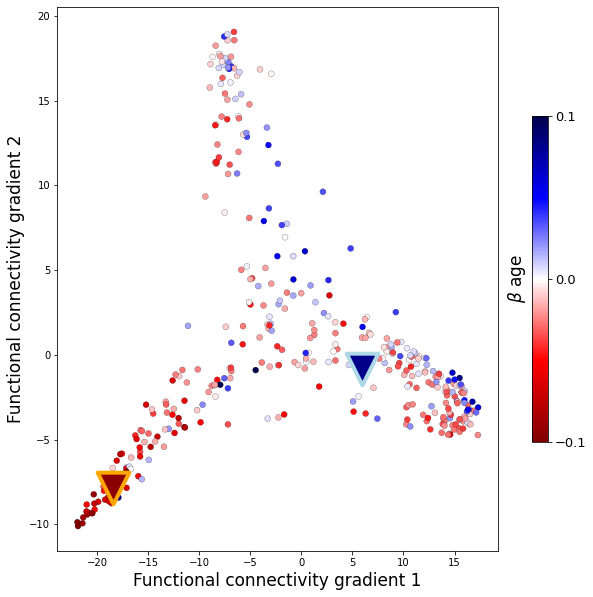

In [350]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib import ticker

orig_map=plt.cm.get_cmap('seismic')
reversed_map = orig_map.reversed()

fig, axs = plt.subplots(1, figsize=(10,10))

axs.scatter(fc_grad1_schaefer, fc_grad2_schaefer, 
    c=thickness_beta_schaefer, cmap=reversed_map,
    edgecolor='black', lw=0.2)
axs.set_xlabel("Functional connectivity gradient 1", size=17)
axs.set_ylabel("Functional connectivity gradient 2", size=17)
axs.scatter(fc_grad1_median_10perc, fc_grad2_median_10perc, s=1000, marker="v", color="darkred", edgecolors='#FFA701', linewidth=4)
axs.scatter(fc_grad1_median_u10perc, fc_grad2_median_u10perc, s=1000, marker="v", color="darkblue", edgecolors='#ADD8E6', linewidth=4)
normalize = mcolors.Normalize(vmin=np.min(thickness_beta_schaefer), 

    vmax=np.max(thickness_beta_schaefer))
s_map = cm.ScalarMappable(norm=normalize, cmap=reversed_map)
cbar = axs.figure.colorbar(s_map, shrink=0.6, pad=0.06)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'$\beta$ age', labelpad=-80, size=17)
tick_locator = ticker.MaxNLocator(nbins=2)
cbar.locator = tick_locator
cbar.update_ticks()

fig.savefig(f"{output_dir}/gradients/gradient_plot.png", dpi=300)